# Read in the data

In [65]:
%matplotlib inline
import pandas
import numpy
import re
import matplotlib.pyplot
from mpl_toolkits.basemap import Basemap
matplotlib.style.use('ggplot')


data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [66]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [67]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [68]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [69]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [70]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [71]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [72]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [73]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# 1. Introduction

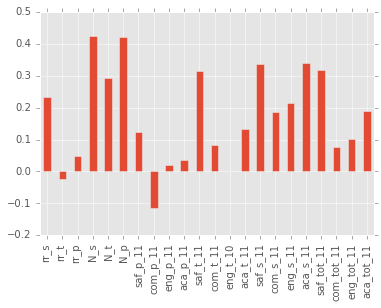

In [74]:
survey_cols = survey_fields[1:]
survey_corr = correlations.loc[survey_cols]
survey_corr.plot.bar()

Comments: Students' participation and scores in the surveys seem to have srong positive correlations with SAT scores while the same is not true for parents' and teachers'.

# 2. Explorint Safety and SAT Scores

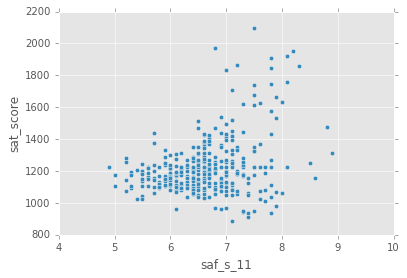

In [75]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

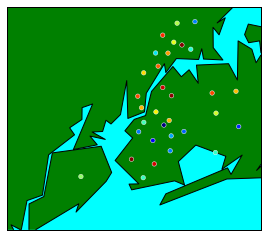

In [76]:
districts = combined.groupby('school_dist').agg(numpy.mean)
m = Basemap(projection='merc', llcrnrlat=40.5, llcrnrlon=-74.3, urcrnrlat=40.9, urcrnrlon=-73.7, resolution='i')
m.drawcoastlines()
m.fillcontinents(color='green', lake_color='aqua')
m.drawmapboundary(fill_color='aqua')
longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter(longitudes, latitudes, zorder=2, latlon=True, c=districts['saf_s_11'])

Comments: It seems that the upper parts of New York have better school safety.

# 3. Exploring Race and SAT Scores

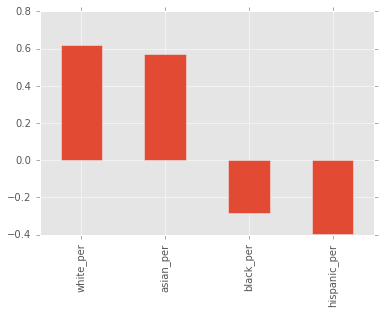

In [77]:
race_corr = correlations.loc[['white_per', 'asian_per', 'black_per', 'hispanic_per']]
race_corr.plot.bar()

Comments: Strong positive correlations between schools that have a majority of White or Asian students with high SAT scores; negative for schools with many Black or Hispanic students.

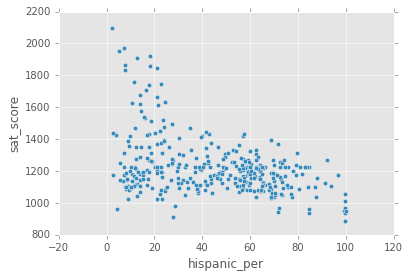

In [78]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

In [79]:
combined['School Name'][combined['hispanic_per'] > 95]

44             MANHATTAN BRIDGES HIGH SCHOOL
82                                         0
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIE
125                                        0
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object

Looks like these schools are primarily for Native Americans.

In [80]:
combined['School Name'][(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]

37                    STUYVESANT HIGH SCHOOL
151             BRONX HIGH SCHOOL OF SCIENCE
187           BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES A
356      STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: School Name, dtype: object

Looks like these schools are in the wealthier neighborhoods and are more technology and science oriented.

# 4. Exploring Gender and SAT Scores

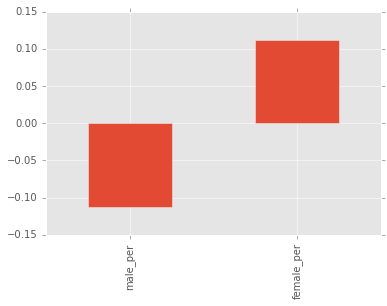

In [81]:
correlations.loc[['male_per', 'female_per']].plot.bar()

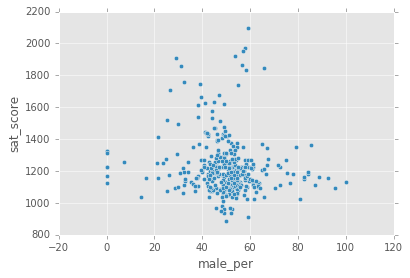

In [82]:
combined.plot.scatter('male_per', 'sat_score')

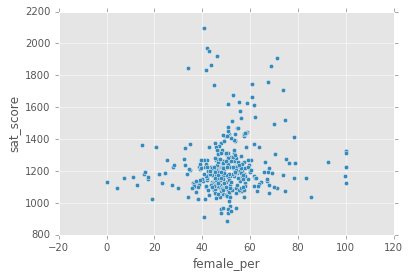

In [83]:
combined.plot.scatter('female_per', 'sat_score')

In [84]:
combined['School Name'][(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]

5            BARD HIGH SCHOOL EARLY COLLEGE
26            ELEANOR ROOSEVELT HIGH SCHOOL
60                       BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF
302             TOWNSEND HARRIS HIGH SCHOOL
Name: School Name, dtype: object

# 5. Exploring AP Scores vs. SAT Scores

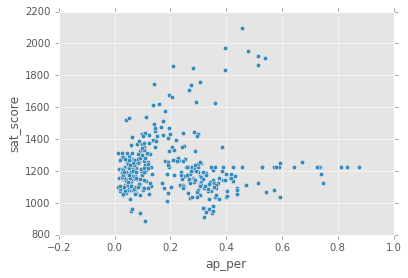

In [86]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot.scatter(x='ap_per', y='sat_score')

In [88]:
correlations = combined.corr()
print(correlations['sat_score']['ap_per'])

0.0571708139077


Comments: Almost no correlations between `ap_per` and `sat_score`.